<a href="https://colab.research.google.com/github/kimathinjoki/twitterTrials/blob/master/twitterTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import Cursor
from tweepy import API
import numpy as np
import pandas as pd


from textblob import TextBlob
import re

# from google.colab import drive
# drive.mount('/content/drive')

# files.download('cridential.ipynb')

# from cridential import Cridential

class Cridential():
    AccessToken = "3117726237-qaOp9Z5ziCGDcrqTeEoOoA958rSAl7fLl08s4wq"
    AccessTokenSecret ="nkj1aARQfqt6eOm4wlNFfloIYZIUYidY7JD767Q3FzdvR"
    ConsumerKey = "bT9VebwnrC42hDhLbtESioyXs"
    ConsumerSecret = "l6nShqaUKvhZest1dFBAJdrVyPOTpvdQ294HPLnnU9ZQdH0Ch1"
    Debug = True

 # the user is nione because we've not specified so likely it will go to my tl, specify the user at the none area
class TwitterClients():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user


    def get_twitter_client_api(self):
        return self.twitter_client
    

    def get_user_timeline_tweets(self,num_tweets):
        tweets = [] 
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friends_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends,id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    def get_home_timeline(self,num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets


    # twitter authenticator class
class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(Cridential.ConsumerKey, Cridential.ConsumerSecret)
        auth.set_access_token(Cridential.AccessToken, Cridential.AccessTokenSecret)

        return auth

class TwitterStreamer():

    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()

    """
    class for streaming and processing live tweets.
    """
    def stream_tweets(self,fetched_tweets_filename, hashtag_list):
    #this hundles tweeter authentication and the connection to the  twiotter streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()


        stream = Stream( auth, listener)

        stream.filter(track=hashtag_list)



class TwitterListener (StreamListener):
    """
    this a bsaic listener class that just prints recieved tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try: 
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
       
            return True
        except BaseException as e:
            print("Error on data:%s" %str(e))
        return True
 # prints out the Error
    def on_error(self, status):
        if status == 420:
            # return false on data incase rate limit occurs from twitter
            return False
        print(status)

 

class TweetAnalyzer():
  
    """
    Functionality for analyzing and categorizing content from tweets.
    """

    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1


 # functionality for analyzing and categorizing content from tweets.

    def tweet_to_data_frame(self,tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])


        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df


if __name__ == "__main__":

    # hashtag_list =["uhuru kenyatta", "covid19", "curfew", "ruto", "lockdown", "quarentine", "mutahi kagwe"]
    # fetched_tweets_filename ="tweets.json"


 # in the client bracket add the users you want
    twitter_client = TwitterClients()

    
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="BarackObama", count=200)

   


# the below shows the part of the tweet
    #print(dir(tweets[0]))

#  the below line shows exactly what you lookig for in a tweet, id, location, time
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweet_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['Tweets']])


    print(df.head(20))


                                               Tweets  ...  sentiment
0   As Chicago navigates the health crisis, its re...  ...          0
1   Congrats to the high school Class of 2020, as ...  ...          1
2   RT @ObamaFoundation: It’s time to #GraduateTog...  ...          1
3   Congratulations to the HBCU Class of 2020! Mic...  ...          1
4   Graduating is a big achievement no matter what...  ...          0
5                                               Vote.  ...          0
6   Michelle and I want to do our part to give all...  ...          0
7   Despite all the time that’s been lost, we can ...  ...          1
8   Change comes when all of us step up and play o...  ...          1
9   Even if you can’t give the moms in your life a...  ...          0
10  There’s no limit to the devotion I’ve seen in ...  ...          0
11  I’ve always loved joining commencements––the c...  ...          1
12  The folks of the Chicago @fooddepository—and f...  ...          0
13  The pandemic has

In [23]:
df.likes.max()

4089349

In [0]:
import matplotlib.pyplot as plt

In [25]:
time_likes =pd.Series(data=df['likes'].values, index=df['date'])
time_likes

date
2020-05-20 21:34:17     42661
2020-05-17 01:00:04    559942
2020-05-16 23:54:47         0
2020-05-16 21:47:43    176758
2020-05-16 16:00:01    156658
                        ...  
2019-05-20 23:04:03         0
2019-05-20 18:50:12    116658
2019-05-12 15:32:16    724087
2019-05-09 16:18:19     33322
2019-05-06 16:18:57         0
Length: 200, dtype: int64

<function matplotlib.pyplot.show>

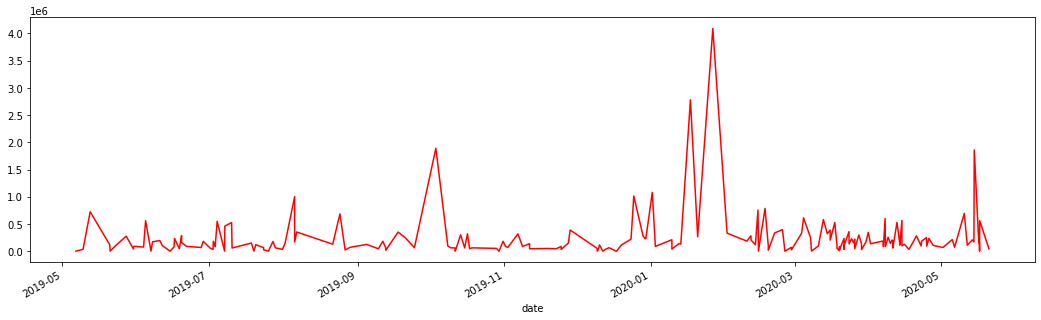

In [26]:
time_likes.plot(figsize=(18,5), color='r')
plt.show

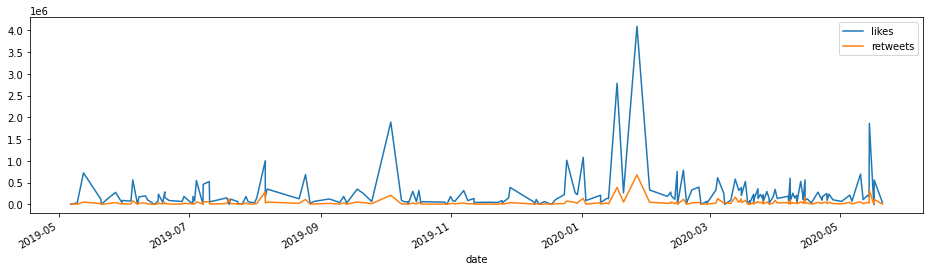

In [18]:
# Layered Time Series:
time_likes = pd.Series(data=df['likes'].values, index=df['date'])
time_likes.plot(figsize=(16, 4), label="likes", legend=True)

time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)
plt.show()